In [1]:
import os

notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '../'))
os.chdir(project_root)

import sys
sys.path.append(project_root)

%load_ext autoreload
%autoreload 2

In [89]:
import numpy as np
import pandas as pd

from src.config import CCY_PAIRS, START_DATE, END_DATE
from src.data_utils import get_fx_data, compute_log_ret, to_binary, to_float, get_min_max_info

In [6]:
df = get_fx_data(CCY_PAIRS, START_DATE, END_DATE, df=True)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


<Axes: xlabel='Date'>

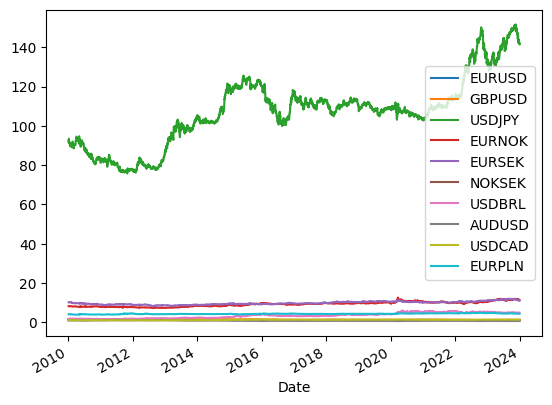

In [7]:
df.plot()

In [8]:
df = compute_log_ret(df)

In [12]:
features = to_binary(df)

In [13]:
features

,USDCAD_01,USDCAD_02,USDCAD_03,USDCAD_04,USDCAD_05,USDCAD_06,USDCAD_07,USDCAD_08,USDCAD_09,USDCAD_10,...,USDBRL_07,USDBRL_08,USDBRL_09,USDBRL_10,USDBRL_11,USDBRL_12,USDBRL_13,USDBRL_14,USDBRL_15,USDBRL_16
0,0,1,1,1,1,1,1,0,1,0,...,1,1,0,1,1,0,0,1,0,1
1,0,1,1,0,0,1,1,0,0,0,...,0,1,1,1,0,1,1,1,1,1
2,1,0,0,0,1,1,0,1,0,0,...,1,1,1,1,0,1,0,1,1,1
3,0,1,1,1,0,0,1,1,1,1,...,0,0,0,1,0,1,1,1,0,1
4,1,0,0,1,0,1,0,0,1,1,...,1,0,1,0,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3635,0,1,1,1,1,1,0,0,0,0,...,1,1,0,0,1,1,1,0,0,1
3636,1,0,0,0,0,0,1,0,1,0,...,1,1,1,1,0,0,1,0,1,0
3637,0,1,1,1,0,0,1,1,0,1,...,1,0,0,0,0,0,0,0,1,1
3638,1,0,0,0,0,1,1,0,1,1,...,0,0,1,0,1,1,1,1,0,1


In [14]:
features.to_numpy()

array([[0, 1, 1, ..., 1, 0, 1],
       [0, 1, 1, ..., 1, 1, 1],
       [1, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 1, 1, ..., 0, 1, 1],
       [1, 0, 0, ..., 1, 0, 1],
       [1, 0, 0, ..., 1, 1, 1]])

In [15]:
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

rbm = BernoulliRBM(n_components=256, 
                   learning_rate=0.1, 
                   batch_size=10, 
                   n_iter=20, 
                   random_state=42, 
                   verbose=True)

rbm.fit(features.to_numpy())

[BernoulliRBM] Iteration 1, pseudo-likelihood = -106.60, time = 0.23s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -104.84, time = 0.31s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -102.39, time = 0.27s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -100.58, time = 0.30s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -101.27, time = 0.30s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -101.41, time = 0.26s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -99.65, time = 0.27s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -98.01, time = 0.23s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -97.71, time = 0.27s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -95.49, time = 0.25s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -98.58, time = 0.25s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -96.93, time = 0.26s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -96.94, time = 0.27s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -100.37, time = 0.24s
[BernoulliRBM] Iterati

BernoulliRBM(n_iter=20, random_state=42, verbose=True)

In [16]:
def generate_synthetic_samples(rbm, n_samples=1, n_gibbs_steps=100):
    """
    Generate synthetic samples using Gibbs sampling.

    Parameters:
      rbm: BernoulliRBM
        Trained RBM model.
      n_samples: int
        Number of synthetic samples to generate.
      n_gibbs_steps: int
        Number of Gibbs sampling steps to perform.

    Returns:
      synthetic_samples: ndarray
        Array of shape (n_samples, n_features) containing synthetic samples.
    """
    synthetic_samples = np.random.rand(n_samples, rbm.n_features_in_) < 0.5  # Initialize with random binary values

    for _ in range(n_gibbs_steps):
        synthetic_samples = rbm.gibbs(synthetic_samples)

    return synthetic_samples

In [104]:
synth = generate_synthetic_samples(rbm, n_samples=30)

In [105]:
synth = pd.DataFrame(synth)
synth = synth.astype(int)
synth.columns = features.columns

In [106]:
min_max = get_min_max_info(df)

In [107]:
res = to_float(synth, min_max)

In [115]:
instr='USDCAD'

In [118]:
X_real = (min_max[instr][0] + res * (min_max[instr][1] - min_max[instr][0]) / 65535)

In [119]:
pd.DataFrame(X_real, columns=[instr])

,USDCAD
0,-0.004864
1,-0.001403
2,-0.001901
3,-0.004232
4,-0.001212
5,-0.003567
6,-0.004443
7,-0.003410
8,-0.003331
9,-0.005882


In [108]:
res

0     28789
1     32469
2     31940
3     29461
4     32673
5     30168
6     29237
7     30335
8     30419
9     27707
10    32309
11    23761
12    22757
13    28236
14    31716
15    32283
16    28146
17    32208
18    29007
19    30205
20    30918
21    28979
22    31062
23    29934
24    32561
25    30207
26    32738
27    28269
28    31393
29    28555
Name: USDCAD, dtype: int64

In [91]:
get_min_max_info(df)

{'USDCAD': [-0.0319381679597881, 0.029692673692160075],
 'USDJPY': [-0.03796100025217285, 0.03748467743357156],
 'EURPLN': [-0.03197035026320121, 0.03479261479555058],
 'EURNOK': [-0.052031585881546986, 0.05350208234119394],
 'EURSEK': [-0.020759411438760412, 0.02827200059949109],
 'EURUSD': [-0.028144080771163097, 0.031262324758573316],
 'AUDUSD': [-0.041266121501451584, 0.028532926147473537],
 'GBPUSD': [-0.07908477228809001, 0.03030790933040477],
 'NOKSEK': [-0.03647251810176716, 0.03916921475768578],
 'USDBRL': [-0.06380101045012901, 0.0724972866792708]}

In [88]:
res

,USDCAD,USDJPY,EURPLN,EURSEK,EURNOK,EURUSD,AUDUSD,GBPUSD,NOKSEK,USDBRL
0,31991,44746,36402,32032,32178,22609,40462,47577,33751,31080
1,32021,39932,35488,26687,30102,29859,36130,42938,34567,27553
2,32679,48878,34679,29574,27290,26929,37134,46847,33533,64069
3,30830,33341,37088,31077,31623,26570,41864,48211,36524,32483
4,31933,37686,33981,32322,31655,24648,38945,48775,38551,23601
5,32739,34784,33155,25762,30073,20322,36504,33687,37797,51707
6,28262,39636,34803,24442,31522,61397,41394,48735,32948,22286
7,23787,36112,34334,32160,29439,32431,39970,48996,33698,32611
8,32545,33877,33637,26339,31642,11995,57000,48787,34623,63380
9,25980,38869,33415,25142,30612,28255,48105,62915,34005,64621


In [37]:
synth

,USDCAD_01,USDCAD_02,USDCAD_03,USDCAD_04,USDCAD_05,USDCAD_06,USDCAD_07,USDCAD_08,USDCAD_09,USDCAD_10,...,USDBRL_07,USDBRL_08,USDBRL_09,USDBRL_10,USDBRL_11,USDBRL_12,USDBRL_13,USDBRL_14,USDBRL_15,USDBRL_16
0,0,1,1,0,1,0,0,0,0,0,...,1,1,0,1,0,0,0,0,1,1
1,0,1,1,1,1,1,0,1,0,1,...,1,1,1,1,1,0,1,0,1,0
2,0,1,1,1,0,1,0,0,0,1,...,1,0,1,1,1,1,1,1,1,1
3,0,1,1,1,1,1,0,0,1,0,...,0,0,0,0,0,0,1,0,1,1
4,0,1,1,1,1,1,1,1,1,1,...,0,1,1,0,0,1,0,1,0,1
5,0,1,1,1,0,0,1,1,1,1,...,1,1,0,1,1,0,0,1,0,0
6,0,1,1,1,1,0,1,1,0,1,...,1,0,0,0,1,0,0,1,1,1
7,0,1,1,1,1,1,0,1,1,1,...,1,1,0,0,0,0,0,1,1,0
8,0,1,1,1,1,0,1,0,0,1,...,1,0,1,1,0,1,0,0,0,1
9,0,1,1,0,1,1,1,1,0,0,...,0,1,1,1,0,0,0,0,1,0


In [32]:
set([s.split('_')[0] for s in synth.columns])

{'AUDUSD',
 'EURNOK',
 'EURPLN',
 'EURSEK',
 'EURUSD',
 'GBPUSD',
 'NOKSEK',
 'USDBRL',
 'USDCAD',
 'USDJPY'}

In [33]:
# Group the binary columns by currency pair
grouped = synth.groupby(lambda x: x.split('_')[0], axis=1)

# Concatenate the values for each currency pair to form a single column
for ccy, group in grouped:
    synth[f'{ccy}'] = group.apply(lambda row: ''.join(map(str, row)), axis=1)

In [34]:
synth

,USDCAD_01,USDCAD_02,USDCAD_03,USDCAD_04,USDCAD_05,USDCAD_06,USDCAD_07,USDCAD_08,USDCAD_09,USDCAD_10,...,AUDUSD,EURNOK,EURPLN,EURSEK,EURUSD,GBPUSD,NOKSEK,USDBRL,USDCAD,USDJPY
0,0,1,1,1,1,1,0,1,1,1,...,1001000100111001,0110100110111010,1000000100100101,0110111111101000,1110100001001010,1001101101100000,1000011001001110,0111001000001011,0111110111101111,0011011111011000
1,0,1,1,0,1,1,1,1,0,0,...,1001011100101110,0110100101111011,1000100010111100,0110001101000011,0111001111100000,1011110111010011,1000101110111110,0111010110011111,0110111100110100,1011111011110110
2,0,1,1,0,1,1,1,0,1,1,...,1010110101101001,0111001011010111,1000000111100100,0110110000111111,0101100001001100,1011010111011100,1000011010001101,0101001111110111,0110111011100011,1000100111010000
3,0,1,1,1,1,1,0,1,0,1,...,1001110001100010,0111111000110111,1000010010011111,0111100011000010,0110100001010011,1011111101100000,1001000011100011,1000111111100110,0111110101001101,1000110101101000
4,0,1,1,1,1,0,0,1,1,1,...,1001110101111000,0111010001111101,1000011011111011,0110011110010110,0111101110101111,1011111111000011,1000101110001100,0110000100010111,0111100111101011,1010101111101011
5,0,1,1,1,1,1,1,0,0,0,...,1010101011110101,0111011110110111,1001001010000101,0110101011101101,0111110101011110,1011101110010000,1000101111010111,0110111100110011,0111111000001011,1000001110000111
6,0,1,1,1,0,1,0,0,0,1,...,1001011111110010,0110011001100111,1000001110101101,0111110101011010,0111111011001100,1010111111101001,1000101111001101,0110111001000001,0111010001011101,0011101010011010
7,0,1,1,1,0,1,1,1,1,0,...,1010100000011010,0110111010111111,1000010010001111,0101101000011001,0110010000111011,1011101100011101,1000010111101111,0111100000011101,0111011110100111,0010111011010110
8,0,1,1,1,1,1,0,0,1,0,...,1001110000100001,0111010110011011,1000000010110011,0110010011010110,0110111110011011,1010000100011010,1000111110111110,1110110000010100,0111110010110101,1001101011101101
9,0,1,1,0,1,1,1,1,0,1,...,1001110111110000,0111001010001101,1000010010000011,0110101111100101,0111110001011111,1011011111101001,1000000101100110,0100001000100111,0110111101001001,1011111100100010


In [29]:
synth

,USDCAD_01,USDCAD_02,USDCAD_03,USDCAD_04,USDCAD_05,USDCAD_06,USDCAD_07,USDCAD_08,USDCAD_09,USDCAD_10,...,USDBRL_07,USDBRL_08,USDBRL_09,USDBRL_10,USDBRL_11,USDBRL_12,USDBRL_13,USDBRL_14,USDBRL_15,USDBRL_16
0,0,1,1,1,1,1,0,1,1,1,...,1,0,0,0,0,0,1,0,1,1
1,0,1,1,0,1,1,1,1,0,0,...,0,1,1,0,0,1,1,1,1,1
2,0,1,1,0,1,1,1,0,1,1,...,1,1,1,1,1,1,0,1,1,1
3,0,1,1,1,1,1,0,1,0,1,...,1,1,1,1,1,0,0,1,1,0
4,0,1,1,1,1,0,0,1,1,1,...,0,1,0,0,0,1,0,1,1,1
5,0,1,1,1,1,1,1,0,0,0,...,1,1,0,0,1,1,0,0,1,1
6,0,1,1,1,0,1,0,0,0,1,...,1,0,0,1,0,0,0,0,0,1
7,0,1,1,1,0,1,1,1,1,0,...,0,0,0,0,0,1,1,1,0,1
8,0,1,1,1,1,1,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
9,0,1,1,0,1,1,1,1,0,1,...,1,0,0,0,1,0,0,1,1,1
